<h1>Pricing Options With Methods from Stochastic Calculus and Monte Carlo Methods</h1>

<p>Pricing vanilla options and a few other type of options such as digital options is analytically tractable using methods from stochastic calculus and Black Scholes option pricing formula. Exotic options such as Parisian options or Bermudan options does not yet have any anlytical solution. These options can sometimes be priced efficiently using finite difference methods. However, these often suffer from the "curse of dimensionality". The "curse of dimensionality" refers to the exponentially growing runtime complexity of numerical finite difference methods. To overcome this Monte Carlo methods are often employed due to their ability to price high-dimensionality options. However, this often come at the price of reduced accuracy.</p>

<p>In this presentation we will:</p>
<ol>
    <li>Price an option using methods from stochastic calculus. Price the same option using Monte Carlo to verify that it works.</li>
    <li>Price the same option again using Monte Carlo with importance sampling.</li>
    <li>Price a Parisian option using Monte Carlo without and with antithetic sampling.</li>
</ol>


In [188]:
# importing libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib

# setting important parameters
s0 = 100
K = 115
sigma = 0.05
tau = 1
r = 0.05
mu_prime = 0.15 # alternative drift for importance sampling
trigger = 0.3 # time spent in the money to trigger payoff for parisian

N = 10000  # number of simulations to run in MC
B = 1000 # number of bootstrap samples
time_steps = 100
time = np.linspace(0, tau, time_steps)

alpha = 0.05 # 1 - confidence level for confidence intervals

In [189]:
def black_scholes(s0, K, sigma, tau, r):
    d1 = (np.log(s0/K) + (r+sigma**2/2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return norm.cdf(d1)*s0 - norm.cdf(d2)*K*np.exp(-r*tau)

def monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic = False):
    dt = tau/time_steps
    if antithetic:
        dW = np.random.normal(size=(N//2, time_steps))
        random_walks = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW
        random_walks_anti = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*(-dW)

        random_walks = np.vstack([random_walks, random_walks_anti])
    else:
        dW = np.random.normal(size=(N, time_steps))
        random_walks = (r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*dW

    random_walks = random_walks.cumsum(axis=1)
    random_walks = s0*np.exp(random_walks)
    final_values = random_walks[:, -1]
    mc_call_value = np.exp(-r*tau)*np.mean(np.maximum(final_values - K, 0))

    return mc_call_value, random_walks

def monte_carlo_parisian(s0, K, sigma, tau, r, trigger, N, time_steps, antithetic = False):
    dt = tau/time_steps
    random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic)[1]

    time_spent_itm = np.sum(np.where(random_walks >= K, dt, 0), axis = 1)
    final_values = random_walks[:, -1]
    payoff = np.exp(-r*tau)*np.mean(np.where((final_values >= K) & (time_spent_itm >= trigger), final_values-K, 0))

    random_walks_itm = random_walks[(final_values >= K) & (time_spent_itm >= trigger), :]
    random_walks_otm = random_walks[~((final_values >= K) & (time_spent_itm >= trigger)), :]

    return payoff, random_walks_itm, random_walks_otm
    


<h3>1. Price an option using methods from stochastic calculus. Price the same option using Monte Carlo to verify that it works.</h3>

Using Monte Carlo is quite straightforward. First we simulate different price paths according to the geometric brownian motion $dS_t = \mu S_t dt + \sigma dW_t $ where $\mu = r-\frac{1}{2}\sigma$. After simulating the price paths we calculate the payoff of at maturity $T$ of call $i$ corresponding to the $i$-th simulated pricepath $C_{T, i} = \max(S_T-K, 0)$. Taking the average payoff $\bar{C} = \frac{1}{N}\sum_{i=1}^{N} C_{T,i}$ and discounting by a factor $e^{-rt}$ will give us the price for a call option. That is $C \simeq \bar{C}e^{-rt}$.


Pricing with Monte Carlo: 0.08022878040204365
Pricing with Black Scholes: 0.07553570064894455


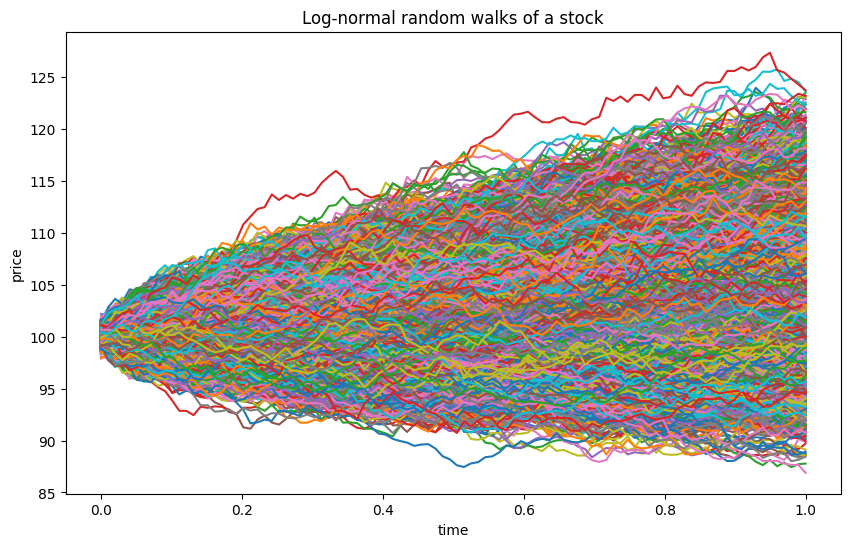

In [190]:
mc_call_value, random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps)
bs_call_value = black_scholes(s0, K, sigma, tau, r)


print(f"Pricing with Monte Carlo: {mc_call_value}")
print(f"Pricing with Black Scholes: {bs_call_value}")


plt.figure(figsize=(10, 6))
plt.plot(time, random_walks.T)
plt.xlabel("time")
plt.ylabel("price")
plt.title("Log-normal random walks of a stock")
plt.show()

<h5>1.2 Bootstrapping the Monte Carlo estimates</h5>

We did get quite a good estimate using Monte Carlo methods. However, this estimate is not deterministic, so we are interested in the variance. We can estimate the variance using bootstrapping. That is we simulate $\bar{C}^b, b \in [1,\dots,B]$. We then calculate the empirical mean and variance of $\bar{C}$.

In [191]:
bootstrapped_mc_call = []

for i in range(B):
    bootstrapped_mc_call.append(monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps)[0])

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"True value of call: {bs_call_value}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")

Mean of bootstrap estimates: 0.07563253868691645
True value of call: 0.07553570064894455
Standard deviation of bootstrapped estimates: 0.005656045225040782
95% confidence interval: [0.0648786746155613, 0.08665622502234932]


<h5>1.3 Reducing the variance</h5>

We want as presice measures as possible. We can achieve this through antithetic sampling. Given samples $X_i, i \in [1,\dots, n]$ you create antithetic samples $\tilde{X_i} = -X_i, i \in [1,\dots, n]$. Making the antithetic samples the negative of the original samples induces negative correlation between the samples and reduces the variance. We know that the variance of $2n$ samples from previous calculations is $\text{Var}[\frac{1}{2n}\sum_{1}^{2n}X_i] = \frac{1}{2n}\sigma^2$ The variance with the antithetic samples can be written as:

\begin{align*}
    \text{Var[samples + antithetic samples]} &= \text{Var}[\frac{1}{2n}\sum_{i=1}^{n}X_i + \frac{1}{2n}\sum_{i=1}^{n}\tilde{X_i}] \\
    &=\frac{1}{(2n)^2}\text{Var}[\sum_{i=1}^{n}X_i] + \frac{1}{(2n)^2}\text{Var}[\sum_{i=1}^{n}\tilde{X_i}] + 2\text{Cov}[\sum_{i=1}^{n}X_i, \sum_{1}^{n}\tilde{X_i}]\\
    &= \frac{n}{(2n)^2}\sigma^2 + \frac{n}{(2n)^2}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{2n}{(2n)^2}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{1}{2n}\sigma^2 + 2\sum_{i=1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &< \frac{1}{2n}\sigma^2
\end{align*}

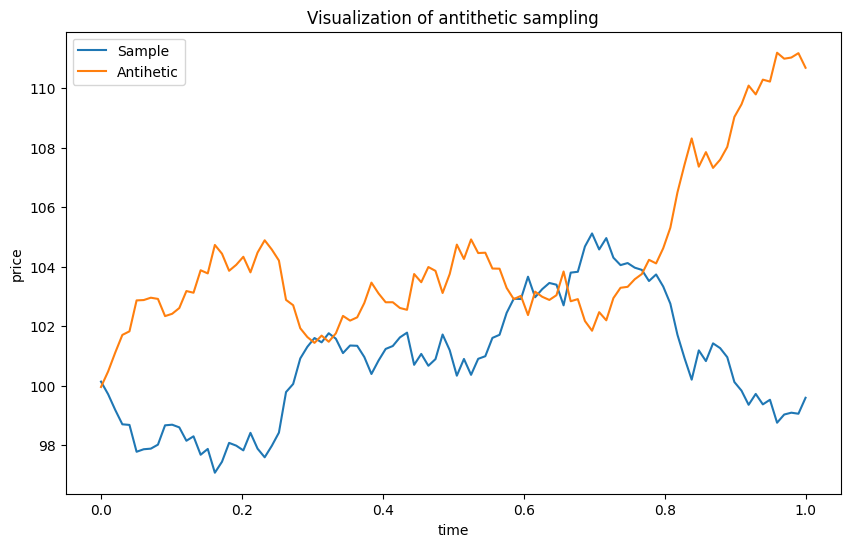

In [192]:
mc_call_value, random_walks = monte_carlo_vanilla(s0, K, sigma, tau, r, 2, time_steps, antithetic=True)

plt.figure(figsize=(10, 6))
plt.plot(time, random_walks.T, label=["Sample", "Antihetic"])
plt.legend()
plt.xlabel("time")
plt.ylabel("price")
plt.title("Visualization of antithetic sampling")
plt.show()

In [ ]:
bootstrapped_mc_call = []

for i in range(B):
    bootstrapped_mc_call.append(monte_carlo_vanilla(s0, K, sigma, tau, r, N, time_steps, antithetic=True)[0])

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"True value of call: {bs_call_value}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")

<h3>2 Using importance sampling</h3>

As a simple example, consider estimating the expecation of a function of a 1-dimensional random variable, $X \sim p$, by $\mathbb{E}^p[g(X)] = \int_{\mathbb{R}}g(x)p(x)dx \approx \frac{1}{n}\sum_{i=1}^n g(X_i) =: \hat{\mu}$, where $X_i \overset{\text{i.i.d.}}{\sim} p$. Then, since $X_i$ are independent, we have 

\begin{align*}
Var(\hat{\mu}) &= \frac{1}{n^2}\sum_{i=1}^n Var_p(g(X_i))\\
&=\frac{1}{n}Var_p(g(X))
\end{align*}

However, note that the integral above can be rearranged, to give:

\begin{align*}
\mathbb{E}^p[g(X)]  &= \int_{\mathbb{R}}g(x)p(x)dx \\
                    &= \int_{\mathbb{R}}g(x)\frac{p(x)}{q(x)}q(x)dx \\
                    &= \mathbb{E}^q\bigg[g(X)\frac{p(X)}{q(X)}\bigg]\\ 
                    &\approx \frac{1}{n}\sum_{i=1}^n g(X_i) \frac{p(X_i)}{q(X_i)}, \hspace{2mm}\text{where} \hspace{2mm} X_i \overset{\text{i.i.d.}}{\sim} q\\
                    &= \tilde{\mu}

\end{align*}

Where 

\begin{align}
Var(\tilde{\mu}) &=\frac{1}{n}Var_q\left(g(X)\frac{p(X)}{q(X)}\right)

\end{align}

Such that $Var(\tilde{\mu}) < Var(\hat{\mu})$ if and only if 

\begin{align*}

\int_{\mathbb{R}}g(x)^2 \frac{p(x)^2}{q(x)}dx < \int_{\mathbb{R}}g(x)^2 p(x) dx

\end{align*}

Which is possiblle to attain with the right choice of $q$. From (1) we see that the optimal choice of $q$ is $q \propto gp$, when the variance of $\tilde{\mu}$ becomes 0. This shows that we can reduce the variance of our Monte-Carlo estimator by simulating from a different distribution, and then multiplying by a correcting factor, such that our estimator remains unbiased. However, how does this work when our random variable X is path valued, for example with $X = X_{0:T}$ being a Geometric Brownian Motion on $0 \leq t \leq T$?

Well, we can apply Girsanov's theorem. Suppose $X$ and $Y$ are (one-dimesional) Itô diffusions satisifying 

\begin{align*}

dX_t =& b(X_t)dt + \sigma(X_t)dW_t\\
dY_t =& (b(Y_t) + \gamma(Y_t, t))dt + \sigma(Y_t)dW_t

\end{align*}

Then, we can define 

\begin{align*}

u(t) &= \frac{\gamma(t)}{\sigma(Y_t)}\\
M_t &= \exp\left( - \int_0^t u(s)dW_s - \frac{1}{2}\int_0^tu(s)^2ds\right)\\
dQ = M_tdP
\end{align*}

Then, the P-law of X is the same as the Q-law of Y, and in particular, we have 

\begin{align*}

\mathbb{E}^P[g(X_{0:T})] &= \mathbb{E}^Q[g(Y_{0:T})] \\
                         &= \mathbb{E}^P[g(Y_{0:T})M_T] \\
\end{align*}

(Stochastic Differential Equations, Øksendal, 2013, Theorem 8.6.3)

Which allows us to simulate paths under a different drift, and still construct an unbiased Monte-Carlo estimate of $g(X)$. As a concrete example, we can take 

\begin{align*}

dX_t &= rX_tdt + \sigma X_tdW_t\\
dYt &= \mu Y_tdt + \sigma Y_tdW_t

\end{align*}

Which gives 

\begin{align*}

u(t) &= \frac{\mu - r}{\sigma} := u\\
M_t &= \exp\left( - uW_t - \frac{1}{2}u^2t\right) 

\end{align*}

In [94]:
def monte_carlo_vanilla_with_importance_sampling(s0, K, sigma, tau, r, mu, N):
    dt = tau / time_steps

    dW = np.random.normal(size=(N, time_steps))
    random_walks = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW

    log_S_paths = np.log(s0) + random_walks.cumsum(axis=1)
    S_paths = np.exp(log_S_paths)

    W_T = (log_S_paths[:, -1] - np.log(s0) - (mu - 0.5 * sigma**2) * tau) / sigma
    
    payoff = np.maximum(S_paths[:, -1] - K, 0)

    # Adjust the payoffs with the likelihood ratios, M_T
    u = (mu - r) / sigma
    M_T = np.exp(-u * W_T - 0.5 * u**2 * tau)
    adjusted_payoffs = np.exp(-r * tau) * payoff * M_T

    option_price = np.mean(adjusted_payoffs)

    return option_price, S_paths, M_T

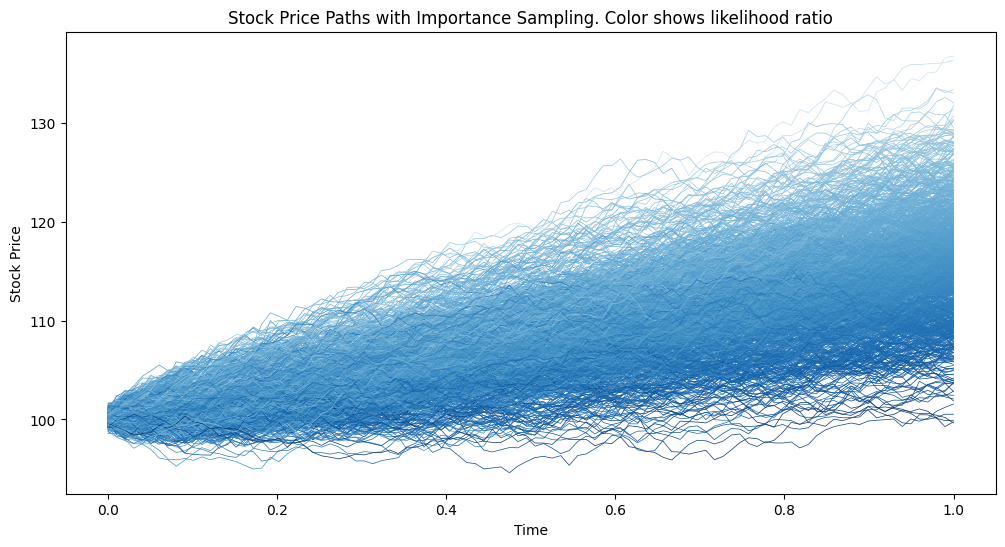

In [95]:
option_price, S_paths, M_T = monte_carlo_vanilla_with_importance_sampling(
    s0, K, sigma, tau, r, mu_prime, N)

t = np.linspace(0, tau, time_steps)

M_T_shifted = M_T - np.min(M_T) + 1e-8  
gamma = 0.05
M_T_transformed = M_T_shifted ** gamma


M_T_norm = (M_T_transformed - np.min(M_T_transformed)) / (np.max(M_T_transformed) - np.min(M_T_transformed))

colormap = matplotlib.colormaps["Blues"]
colors = colormap(M_T_norm)

plt.figure(figsize=(12, 6))
for idx in range(S_paths.shape[0]):
    plt.plot(t, S_paths[idx, :], color=colors[idx], linewidth=0.5)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths with Importance Sampling. Color shows likelihood ratio')
plt.show()

In [96]:
bootstrapped_mc_call = []

for i in range(B):
    option_price, _, __ = monte_carlo_vanilla_with_importance_sampling(s0, K, sigma, tau, r, mu_prime, N)
    bootstrapped_mc_call.append(option_price)

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"True value of call: {bs_call_value}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")



Mean of bootstrap estimates: 0.07554110169006756
True value of call: 0.07553570064894455
Standard deviation of bootstrapped estimates: 0.0024423770019006454
95% confidence interval: [0.07100109064709054, 0.08042464136768687]


<h3>3. Pricing Parisian option using Monte Carlo with variance reduction</h3>

Antithetic sampling:

Given samples $X_i, i \in [1,\dots, n]$ you create antithetic samples $\tilde{X_i} = -X_i, i \in [1,\dots, n]$. Making the antithetic samples the negative of the original samples induces negative correlation between the samples and reduces the variance. We know that the variance of $2n$ samples from previous calculations is $\text{Var}[\frac{1}{2n}\sum_{1}^{2n}X_i] = \frac{1}{2n}\sigma^2$ The variance with the antithetic samples can be written as:

\begin{align}
    \text{Var[samples + antithetic samples]} &= \text{Var}[\frac{1}{2n}\sum_{1}^{n}X_i + \frac{1}{2n}\sum_{1}^{n}\tilde{X_i}] \\
    &=\frac{1}{(2n)^2}\text{Var}[\sum_{1}^{n}X_i] + \frac{1}{(2n)^2}\text{Var}[\sum_{1}^{n}\tilde{X_i}] + 2\text{Cov}[\sum_{1}^{n}X_i, \sum_{1}^{n}\tilde{X_i}]\\
    &= \frac{n}{(2n)^2}\sigma^2 + \frac{n}{(2n)^2}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{2n}{(2n)^2}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &= \frac{1}{2n}\sigma^2 + 2\sum_{1}^{n}\text{Cov}[X_i, \tilde{X_i}]\\
    &< \frac{1}{2n}\sigma^2

\end{align}

Pricing parisian option with Monte Carlo: 0.012315158150146702


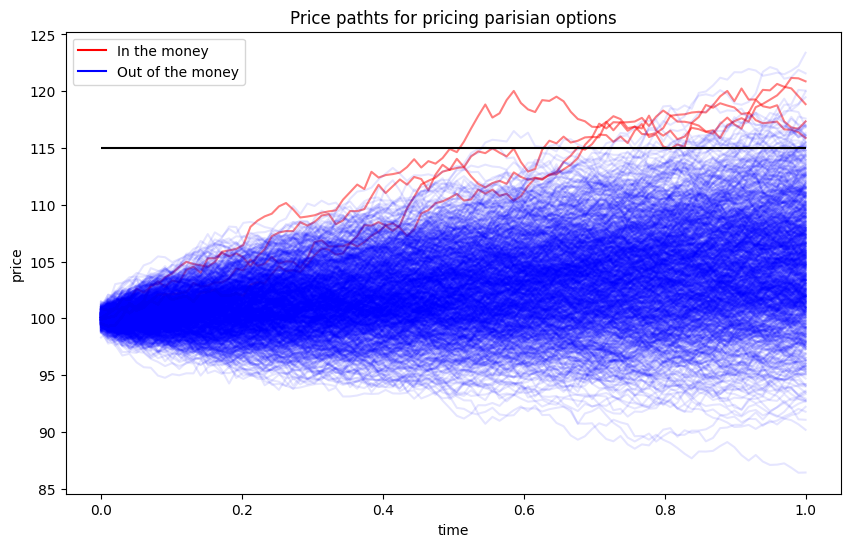

In [97]:
mc_parisian_value, random_walks_itm, random_walks_otm = monte_carlo_parisian(s0, K, sigma, tau, r, trigger, N, time_steps)

print(f"Pricing parisian option with Monte Carlo: {mc_parisian_value}")

plt.figure(figsize=(10, 6))
plt.plot(time, random_walks_itm.T, color="red", alpha=0.5)
plt.plot(time, random_walks_otm.T, color="blue", alpha=0.1)
plt.plot([], [], color="red", label="In the money")
plt.plot([], [], color="blue", label="Out of the money")
plt.legend()
plt.hlines(K, xmin=0, xmax=tau, label="Strike", color="black")
plt.xlabel("time")
plt.ylabel("price")
plt.title("Price paths for pricing parisian options")
plt.show()


In [98]:
bootstrapped_mc_call = []

for i in range(B):
    mc_parisian_value, _, __ = monte_carlo_parisian(s0, K, sigma, tau, r, trigger, N, time_steps)
    bootstrapped_mc_call.append(mc_parisian_value)

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")
print(f"Black-Scholes call (for reference): {bs_call_value}")

Mean of bootstrap estimates: 0.020492727515888536
Standard deviation of bootstrapped estimates: 0.011037362854361405
95% confidence interval: [0.002679160934117175, 0.04520258312510396]
Black-Scholes call (for reference): 0.07553570064894455


In [99]:
def monte_carlo_parisian_with_importance_sampling(s0, K, sigma, tau, r, mu, trigger, N):
    dt = tau / time_steps
    
    dW = np.random.normal(size=(N, time_steps))
    random_walks = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW

    log_S_paths = np.log(s0) + np.cumsum(random_walks, axis=1)
    S_paths = np.exp(log_S_paths)

    W_T = (log_S_paths[:, -1] - np.log(s0) - (mu - 0.5 * sigma**2) * tau) / sigma
    
    time_spent_itm = np.sum(np.where(S_paths >= K, dt, 0), axis=1)
    final_values = S_paths[:, -1]
    payoffs = np.where((final_values >= K) & (time_spent_itm >= trigger), final_values - K, 0)

    # Compute the likelihood ratios M_T
    u = (mu - r) / sigma  
    M_T = np.exp(-u * W_T - 0.5 * u**2 * tau)
    adjusted_payoffs = np.exp(-r * tau) * payoffs * M_T

    option_price = np.mean(adjusted_payoffs)

    itm_mask = (final_values >= K) & (time_spent_itm >= trigger)
    random_walks_itm = S_paths[itm_mask]
    random_walks_otm = S_paths[~itm_mask]

    return option_price, random_walks_itm, random_walks_otm

Pricing parisian option with Monte Carlo: 0.021604451349199135


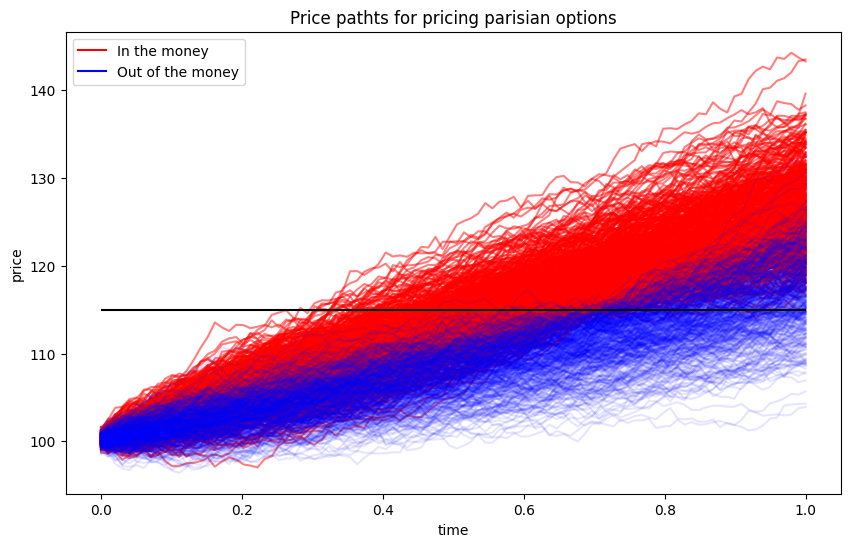

In [100]:
mu = 0.2
mc_parisian_value, random_walks_itm, random_walks_otm = monte_carlo_parisian_with_importance_sampling(s0, K, sigma, tau, r, mu, trigger, N)


print(f"Pricing parisian option with Monte Carlo: {mc_parisian_value}")


plt.figure(figsize=(10, 6))
plt.plot(time, random_walks_itm.T, color="red", alpha=0.5)
plt.plot(time, random_walks_otm.T, color="blue", alpha=0.1)
plt.plot([], [], color="red", label="In the money")
plt.plot([], [], color="blue", label="Out of the money")
plt.legend()
plt.hlines(K, xmin=0, xmax=tau, label="Strike", color="black")
plt.xlabel("time")
plt.ylabel("price")
plt.title("Price paths for pricing parisian options")
plt.show()

In [101]:
bootstrapped_mc_call = []

for i in range(B):
    mc_parisian_value, _, __ = monte_carlo_parisian_with_importance_sampling(s0, K, sigma, tau, r, mu, trigger, N)
    bootstrapped_mc_call.append(mc_parisian_value)

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")
print(f"Black-Scholes call (for reference): {bs_call_value}")

Mean of bootstrap estimates: 0.020656033587928026
Standard deviation of bootstrapped estimates: 0.0013529197236977182
95% confidence interval: [0.018129931152554693, 0.02352502620794467]
Black-Scholes call (for reference): 0.07553570064894455


In [135]:
def monte_carlo_parisian_with_importance_sampling_advanced(s0, K, sigma, T, r, mu, trigger, trigger_to_slow_drift, N):
    dt = T / time_steps
    
    theta = (mu - r) / sigma
    
    S_paths = np.zeros((N, time_steps + 1))
    S_paths[:, 0] = s0
    
    dW_tilde = np.random.normal(size=(N, time_steps)) * np.sqrt(dt)
    cumulative_W_tilde = np.zeros(N)
    
    tau_array = np.full(N, T)
    W_tilde_tau = np.zeros(N)
    theta_dW_tilde_sum = np.zeros(N)
    theta_squared_dt_sum = np.zeros(N)
    
    time_spent_itm = np.zeros(N)
    
    for t in range(time_steps):
        t_current = t * dt
        S_t = S_paths[:, t]
        
        not_triggered = (tau_array == T)
        before_trigger = (S_t < trigger_to_slow_drift) & not_triggered
        
        drift = np.where(before_trigger, mu, r)
        theta_i = np.where(before_trigger, theta, 0.0)
    
        cumulative_W_tilde += dW_tilde[:, t]
        
        theta_dW_tilde_sum += theta_i * dW_tilde[:, t]
        theta_squared_dt_sum += theta_i**2 * dt
        
        just_triggered = (S_t >= trigger_to_slow_drift) & not_triggered
        tau_array[just_triggered] = t_current
        W_tilde_tau[just_triggered] = cumulative_W_tilde[just_triggered]
        
        S_paths[:, t + 1] = S_t * np.exp((drift - 0.5 * sigma**2) * dt + sigma * dW_tilde[:, t])
        
        in_the_money = (S_t >= K)
        time_spent_itm += in_the_money * dt
    
    L_T = np.exp(-theta_dW_tilde_sum - 0.5 * theta_squared_dt_sum)
    
    final_S = S_paths[:, -1]
    payoffs = np.where((final_S >= K) & (time_spent_itm >= trigger), final_S - K, 0.0)
    
    adjusted_payoffs = np.exp(-r * T) * payoffs * L_T
    option_price = np.mean(adjusted_payoffs)
    
    itm_mask = (final_S >= K) & (time_spent_itm >= trigger)
    random_walks_itm = S_paths[itm_mask]
    random_walks_otm = S_paths[~itm_mask]
    
    return option_price, random_walks_itm, random_walks_otm


Pricing parisian option with Monte Carlo: 0.018859127801311115


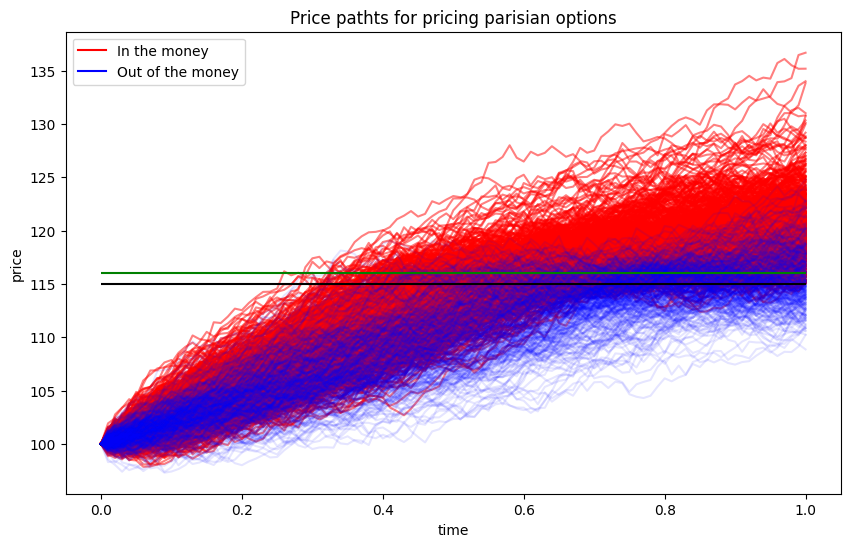

In [186]:
mu = 0.25
trigger_to_slow_drift = 116
mc_parisian_value, random_walks_itm, random_walks_otm = monte_carlo_parisian_with_importance_sampling_advanced(s0, K, sigma, tau, r, mu, trigger,trigger_to_slow_drift, N)

time = np.linspace(0, tau, time_steps+1)

print(f"Pricing parisian option with Monte Carlo: {mc_parisian_value}")


plt.figure(figsize=(10, 6))
plt.plot(time, random_walks_itm.T, color="red", alpha=0.5)
plt.plot(time, random_walks_otm.T, color="blue", alpha=0.1)
plt.plot([], [], color="red", label="In the money")
plt.plot([], [], color="blue", label="Out of the money")
plt.legend()
plt.hlines(K, xmin=0, xmax=tau, label="Strike", color="black")
plt.hlines(trigger_to_slow_drift, xmin=0, xmax=tau, label="Strike", color="green")
plt.xlabel("time")
plt.ylabel("price")
plt.title("Price paths for pricing parisian options")
plt.show()

In [187]:
bootstrapped_mc_call = []

for i in range(B):
    mc_parisian_value, random_walks_itm, random_walks_otm = monte_carlo_parisian_with_importance_sampling_advanced(s0, K, sigma, tau, r, mu, trigger,trigger_to_slow_drift, N)
    bootstrapped_mc_call.append(mc_parisian_value)

bs_call_value = black_scholes(s0, K, sigma, tau, r)

print(f"Mean of bootstrap estimates: {np.mean(bootstrapped_mc_call)}")
print(f"Standard deviation of bootstrapped estimates: {np.std(bootstrapped_mc_call)}")
print(f"{int(100*(1-alpha))}% confidence interval: [{np.quantile(bootstrapped_mc_call, alpha/2)}, {np.quantile(bootstrapped_mc_call, 1 - alpha/2)}]")
print(f"Black-Scholes call (for reference): {bs_call_value}")

Mean of bootstrap estimates: 0.019084899202081545
Standard deviation of bootstrapped estimates: 0.0011282788865615767
95% confidence interval: [0.016919689856230633, 0.021278144494518623]
Black-Scholes call (for reference): 0.07553570064894455
